In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import torch

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
#ID 컬럼 분리
train = train.drop(columns=['ID'], axis = 1)
test = test.drop(columns=['ID'], axis = 1)

In [4]:
import re

def clean_valuation(val):
    if pd.isna(val):
        return None
    if '이상' in val:
        # '6000이상' → 6000
        return int(re.sub('[^0-9]', '', val))
    elif '-' in val:
        # '2500-3500' → 평균값 계산
        low, high = map(int, val.split('-'))
        return (low + high) / 2
    else:
        # 숫자로 변환 가능한 경우
        try:
            return float(val)
        except:
            return None


In [5]:
# 설립연도 -> 연차로 변경
current_year = 2025

train['연차'] = current_year - train['설립연도']
test['연차'] = current_year - test['설립연도']

# 설립연도 제거
train.drop(columns = ['설립연도'], inplace = True)
test.drop(columns = ['설립연도'], inplace = True)

category_features = ['국가','분야']
numeric_features = ['연차', '투자단계', '직원 수','고객수(백만명)','총 투자금(억원)','연매출(억원)','SNS 팔로워 수(백만명)', '기업가치(백억원)']
bool_features = ['인수여부','상장여부']

# 투자단계 순서를 숫자로 매핑
investment_stage_map = {
    'Seed': 0,
    'Series A': 1,
    'Series B': 2,
    'Series C': 3,
    'IPO': 4,
    'Missing': -1
}

# 결측치 먼저 처리 후 매핑
train['투자단계'] = train['투자단계'].fillna('Missing').map(investment_stage_map)
test['투자단계'] = test['투자단계'].fillna('Missing').map(investment_stage_map)

# 기업가치 변환
train['기업가치(백억원)'] = train['기업가치(백억원)'].apply(clean_valuation)
test['기업가치(백억원)'] = test['기업가치(백억원)'].apply(clean_valuation)

# LabelEncoder 객체를 각 범주형 feature별로 따로 저장하여 사용
encoders = {}

# 범주형 데이터를 encoding
for feature in category_features:
    encoders[feature] = LabelEncoder()
    train[feature] = train[feature].fillna('Missing')
    test[feature] = test[feature].fillna('Missing')
    train[feature] = encoders[feature].fit_transform(train[feature])
    test[feature] = encoders[feature].transform(test[feature])

# 불리언 값을 0과 1로 변환 ('Yes' → 1, 'No' → 0 으로 변환)
bool_map = {'Yes': 1, 'No': 0}

for feature in bool_features:
    train[feature] = train[feature].map(bool_map)
    test[feature] = test[feature].map(bool_map)

# 수치형 변수 결측치를 중간값으로 대체
for feature in numeric_features:
    median_value = train[feature].median()
    train[feature] = train[feature].fillna(median_value)
    test[feature] = test[feature].fillna(median_value)

# TabNet용 범주형 변수 인덱스(cat_idxs) 및 차원(cat_dims) 설정
features = [col for col in train.columns if col != '성공확률']
cat_idxs = [features.index(col) for col in category_features]
cat_dims = [train[col].max() + 1 for col in category_features]

In [5]:
# 설립연도 -> 연차로 변경
current_year = 2025

train['연차'] = current_year - train['설립연도']
test['연차'] = current_year - test['설립연도']

# 설립연도 제거
train.drop(columns = ['설립연도'], inplace = True)
test.drop(columns = ['설립연도'], inplace = True)

category_features = ['국가','분야']
numeric_features = ['연차', '투자단계', '직원 수','고객수(백만명)','총 투자금(억원)','연매출(억원)','SNS 팔로워 수(백만명)', '기업가치(백억원)']
bool_features = ['인수여부','상장여부']

# 투자단계 순서를 숫자로 매핑
investment_stage_map = {
    'Seed': 0,
    'Series A': 1,
    'Series B': 2,
    'Series C': 3,
    'IPO': 4,
    'Missing': -1
}

# 결측치 먼저 처리 후 매핑
train['투자단계'] = train['투자단계'].map(investment_stage_map)
test['투자단계'] = test['투자단계'].map(investment_stage_map)

# 기업가치 변환
train['기업가치(백억원)'] = train['기업가치(백억원)'].apply(clean_valuation)
test['기업가치(백억원)'] = test['기업가치(백억원)'].apply(clean_valuation)

# LabelEncoder 객체를 각 범주형 feature별로 따로 저장하여 사용
encoders = {}

# 범주형 데이터를 encoding
for feature in category_features:
    encoders[feature] = LabelEncoder()
    train[feature] = train[feature].fillna('Missing')
    test[feature] = test[feature].fillna('Missing')
    train[feature] = encoders[feature].fit_transform(train[feature])
    test[feature] = encoders[feature].transform(test[feature])

# 불리언 값을 0과 1로 변환 ('Yes' → 1, 'No' → 0 으로 변환)
bool_map = {'Yes': 1, 'No': 0}

for feature in bool_features:
    train[feature] = train[feature].map(bool_map)
    test[feature] = test[feature].map(bool_map)

# # 수치형 변수 결측치를 중간값으로 대체
# for feature in numeric_features:
#     median_value = train[feature].median()
#     train[feature] = train[feature].fillna(median_value)
#     test[feature] = test[feature].fillna(median_value)

# TabNet용 범주형 변수 인덱스(cat_idxs) 및 차원(cat_dims) 설정
features = [col for col in train.columns if col != '성공확률']
cat_idxs = [features.index(col) for col in category_features]
cat_dims = [train[col].max() + 1 for col in category_features]

In [6]:
for df in [train, test]:
    # 1인당 지표
    df['투자_직원수'] = df['총 투자금(억원)'] / df['직원 수']
    df['매출_직원수'] = df['연매출(억원)'] / df['직원 수']

    # 비율 지표
    df['매출_투자'] = df['연매출(억원)'] / df['총 투자금(억원)']
    df['투자_기업가치'] = df['총 투자금(억원)'] / df['기업가치(백억원)']
    df['매출_고객'] = df['연매출(억원)'] / df['고객수(백만명)']

    # 스케일 변환
    df['연차_루트'] = np.sqrt(df['연차'])

    # 추가 파생 피처
    df['기업가치_투자'] = df['기업가치(백억원)'] / df['총 투자금(억원)']
    df['팔로워_고객'] = df['SNS 팔로워 수(백만명)'] / df['고객수(백만명)']
    df['팔로워_기업가치'] = df['SNS 팔로워 수(백만명)'] / df['기업가치(백억원)']
    df['고객_직원수'] = df['고객수(백만명)'] / df['직원 수']
    df['매출_기업가치'] = df['연매출(억원)'] / df['기업가치(백억원)']
    df['매출_연차'] = df['연매출(억원)'] / df['연차']
    df['매출_팔로워'] = df['연매출(억원)'] / (df['SNS 팔로워 수(백만명)'] + 1e-6)


In [7]:
features += [
    '투자_직원수', '매출_직원수', '매출_투자',
    '투자_기업가치', '매출_고객', '연차_루트',
    '기업가치_투자', '팔로워_고객', '팔로워_기업가치',
    '고객_직원수', '매출_기업가치', '매출_연차',
    '매출_팔로워'
]


In [8]:
# features 리스트에서 제거
features = [f for f in features if f not in ['국가', '분야', '투자단계', '인수여부', '상장여부', '직원 수', 'SNS 팔로워 수(백만명)']]


In [ ]:
# 평균값을 딕셔너리로 저장
국가별_연매출_평균_dict = train.groupby('국가')['연매출(억원)'].mean().to_dict()
분야별_고객수_평균_dict = train.groupby('분야')['고객수(백만명)'].mean().to_dict()

for df in [train, test]:
    국가_평균 = df['국가'].map(국가별_연매출_평균_dict)
    분야_평균 = df['분야'].map(분야별_고객수_평균_dict)

    # 분모에 1e6 더함
    df['연매출_국가평균_비율'] = df['연매출(억원)'] / (국가_평균 + 1e6)
    df['고객수_분야평균_비율'] = df['고객수(백만명)'] / (분야_평균 + 1e6)



In [ ]:
features += [
    '연매출_국가평균_비율', '고객수_분야평균_비율'
]

In [13]:
features

['고객수(백만명)',
 '총 투자금(억원)',
 '연매출(억원)',
 '기업가치(백억원)',
 '연차',
 '투자_직원수',
 '매출_직원수',
 '매출_투자',
 '투자_기업가치',
 '매출_고객',
 '연차_루트',
 '기업가치_투자',
 '팔로워_고객',
 '팔로워_기업가치',
 '고객_직원수',
 '매출_기업가치',
 '매출_연차',
 '매출_팔로워',
 '연매출_국가평균_비율',
 '고객수_분야평균_비율']

In [19]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 데이터 분리 (optuna는 fold보다 빠른 실험에 적합)
X_train, X_valid, y_train, y_valid = train_test_split(
    train[features], train['성공확률'], test_size=0.2, random_state=42
)

# DMatrix 변환
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# 1. objective 함수 정의
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03, step=0.001),
        'max_depth': trial.suggest_int('max_depth', 16, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.01),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.01),
        'lambda': 0,
        'alpha': 0,
        'tree_method': 'hist',
        'seed': 42
    }

    model = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dvalid, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = model.predict(dvalid)
    score = mean_absolute_error(y_valid, preds)
    return score  # MAE가 낮을수록 좋음!

# 2. study 실행
study = optuna.create_study(direction='minimize')  # MAE 작을수록 좋음
study.optimize(objective, n_trials=300)  # 원하는 만큼 시도

# 3. 결과 확인
print("✅ Best trial:")
print(study.best_trial)

[I 2025-04-14 20:25:08,263] A new study created in memory with name: no-name-8791fd93-c98a-4ded-bacb-ab6231b637cd
[I 2025-04-14 20:25:09,470] Trial 0 finished with value: 0.1955538991583537 and parameters: {'learning_rate': 0.03, 'max_depth': 17, 'subsample': 0.86, 'colsample_bytree': 0.72}. Best is trial 0 with value: 0.1955538991583537.
[I 2025-04-14 20:25:12,636] Trial 1 finished with value: 0.19452133751282952 and parameters: {'learning_rate': 0.014, 'max_depth': 19, 'subsample': 0.6, 'colsample_bytree': 0.97}. Best is trial 1 with value: 0.19452133751282952.
[I 2025-04-14 20:25:13,915] Trial 2 finished with value: 0.19683535063988 and parameters: {'learning_rate': 0.025, 'max_depth': 17, 'subsample': 0.95, 'colsample_bytree': 0.65}. Best is trial 1 with value: 0.19452133751282952.
[I 2025-04-14 20:25:15,131] Trial 3 finished with value: 0.19902108947163846 and parameters: {'learning_rate': 0.028000000000000004, 'max_depth': 17, 'subsample': 0.99, 'colsample_bytree': 0.96}. Best is

KeyboardInterrupt: 

## 베스트2

In [ ]:
    'learning_rate': 0.01999442928330417,
    'max_depth': 19,
    'subsample': 0.9480568751181326,
    'colsample_bytree': 0.754082682926498,
    'lambda': 0.00160708810021216,
    'alpha': 0.003025787373246697,

## GOAT

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.015,
    'max_depth': 18,
    'subsample': 0.9480568751181326,
    'colsample_bytree': 0.754082682926498,
    'lambda': 0.00160708810021216,
    'alpha': 0,
    'tree_method': 'hist',
    'seed': 42
}

In [ ]:
    'learning_rate': 0.015,
    'max_depth': 18,
    'subsample': 0.65,
    'colsample_bytree': 0.57,
    'lambda': 0,
    'alpha': 0,

In [ ]:
    'learning_rate': 0.015,
    'max_depth': 18,
    'subsample': 0.80,
    'colsample_bytree': 0.79,
    'lambda': 0,
    'alpha': 0,

In [ ]:
    'learning_rate': 0.015,
    'max_depth': 18,
    'subsample': 0.95,
    'colsample_bytree': 0.75,
    'lambda': 0,
    'alpha': 0,

In [ ]:
    'learning_rate': 0.015,
    'max_depth': 18,
    'subsample': 0.77,
    'colsample_bytree': 0.94,
    'lambda': 0,
    'alpha': 0,

In [ ]:
    'learning_rate': 0.01,
    'max_depth': 19,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'lambda': 0,
    'alpha': 0,

In [23]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

X = train[features]
y = train['성공확률']

kf = KFold(n_splits=20, shuffle=True, random_state=42)
models = []
cv_scores = []

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.01,
    'max_depth': 19,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'lambda': 0,
    'alpha': 0,
    'tree_method': 'hist',
    'seed': 42
}


for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold+1}/10")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        early_stopping_rounds=500,
        verbose_eval=100
    )

    preds = model.predict(dvalid)
    score = mean_absolute_error(y_valid, preds)
    print(f"  🔍 Fold {fold+1} MAE: {score:.4f}")

    models.append(model)
    cv_scores.append(score)

print("\n✅ 모든 fold 모델 학습 완료!")
print(f"📉 평균 MAE: {sum(cv_scores)/len(cv_scores):.4f}")



🔁 Fold 1/10
[0]	train-mae:0.20311	valid-mae:0.21044
[100]	train-mae:0.10464	valid-mae:0.19849
[200]	train-mae:0.05433	valid-mae:0.19537
[300]	train-mae:0.02846	valid-mae:0.19372
[400]	train-mae:0.01562	valid-mae:0.19320
[500]	train-mae:0.00874	valid-mae:0.19290
[600]	train-mae:0.00514	valid-mae:0.19277
[700]	train-mae:0.00299	valid-mae:0.19262
[800]	train-mae:0.00173	valid-mae:0.19255
[900]	train-mae:0.00105	valid-mae:0.19252
[1000]	train-mae:0.00068	valid-mae:0.19251
[1100]	train-mae:0.00061	valid-mae:0.19251
[1200]	train-mae:0.00059	valid-mae:0.19251
[1300]	train-mae:0.00058	valid-mae:0.19251
[1400]	train-mae:0.00056	valid-mae:0.19251
[1500]	train-mae:0.00056	valid-mae:0.19251
[1600]	train-mae:0.00055	valid-mae:0.19251
[1700]	train-mae:0.00054	valid-mae:0.19251
[1800]	train-mae:0.00054	valid-mae:0.19251
[1900]	train-mae:0.00054	valid-mae:0.19251
[1934]	train-mae:0.00054	valid-mae:0.19251
  🔍 Fold 1 MAE: 0.1925

🔁 Fold 2/10
[0]	train-mae:0.20419	valid-mae:0.19025
[100]	train-mae:0.10

In [25]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np

X = train[features]
y = train['성공확률']

# ✅ 여러 개 seed 설정
seeds = [13, 42, 77, 123, 999]
n_splits = 20

models = []
cv_scores = []

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'learning_rate': 0.01,
    'max_depth': 19,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'lambda': 0,
    'alpha': 0,
    'tree_method': 'hist'
}

# ✅ seed마다 KFold 10회씩 실행
for seed in seeds:
    print(f"\n🧪 Seed {seed} 시작")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Seed {seed} - Fold {fold+1}/{n_splits}")

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        model = xgb.train(
            params={**params, 'seed': seed},
            dtrain=dtrain,
            num_boost_round=2000,
            evals=[(dtrain, 'train'), (dvalid, 'valid')],
            early_stopping_rounds=1000,
            verbose_eval=100
        )

        preds = model.predict(dvalid)
        score = mean_absolute_error(y_valid, preds)
        print(f"  🔍 Fold MAE: {score:.4f}")

        models.append(model)
        cv_scores.append(score)

# ✅ 전체 결과 출력
print("\n✅ 모든 Seed-Fold 모델 학습 완료!")
print(f"📉 평균 MAE (Across All Seeds): {np.mean(cv_scores):.4f}")



🧪 Seed 13 시작

🔁 Seed 13 - Fold 1/20
[0]	train-mae:0.20386	valid-mae:0.20343
[100]	train-mae:0.10247	valid-mae:0.19651
[200]	train-mae:0.05309	valid-mae:0.19672
[300]	train-mae:0.02756	valid-mae:0.19703
[400]	train-mae:0.01499	valid-mae:0.19750
[500]	train-mae:0.00842	valid-mae:0.19770
[600]	train-mae:0.00486	valid-mae:0.19773
[700]	train-mae:0.00279	valid-mae:0.19774
[800]	train-mae:0.00165	valid-mae:0.19777
[900]	train-mae:0.00101	valid-mae:0.19777
[1000]	train-mae:0.00068	valid-mae:0.19778
[1100]	train-mae:0.00060	valid-mae:0.19778
[1125]	train-mae:0.00059	valid-mae:0.19778
  🔍 Fold MAE: 0.1978

🔁 Seed 13 - Fold 2/20
[0]	train-mae:0.20347	valid-mae:0.20905
[100]	train-mae:0.10424	valid-mae:0.19978
[200]	train-mae:0.05496	valid-mae:0.19779
[300]	train-mae:0.02918	valid-mae:0.19694
[400]	train-mae:0.01580	valid-mae:0.19635
[500]	train-mae:0.00899	valid-mae:0.19618
[600]	train-mae:0.00510	valid-mae:0.19589
[700]	train-mae:0.00296	valid-mae:0.19588
[800]	train-mae:0.00177	valid-mae:0.19

In [24]:
import xgboost as xgb
import numpy as np

# 저장된 모델들로 예측
predictions_list = []

dtest = xgb.DMatrix(test[features])  # ← 여기가 핵심

for fold, model in enumerate(models):
    print(f"Predict with fold {fold+1}")
    preds = model.predict(dtest)  # DMatrix 입력
    predictions_list.append(preds)

# 평균 예측
final_predictions = np.mean(predictions_list, axis=0)

# 제출 파일 생성
sample_submission['성공확률'] = final_predictions
sample_submission.to_csv('./0414_16_submission.csv', index=False, encoding='utf-8-sig')


Predict with fold 1
Predict with fold 2
Predict with fold 3
Predict with fold 4
Predict with fold 5
Predict with fold 6
Predict with fold 7
Predict with fold 8
Predict with fold 9
Predict with fold 10
Predict with fold 11
Predict with fold 12
Predict with fold 13
Predict with fold 14
Predict with fold 15
Predict with fold 16
Predict with fold 17
Predict with fold 18
Predict with fold 19
Predict with fold 20


In [26]:
import xgboost as xgb
import numpy as np

# 저장된 모델들로 예측
predictions_list = []
dtest = xgb.DMatrix(test[features])  # 테스트셋 변환

for fold, model in enumerate(models):
    print(f"Predict with fold {fold+1}")
    preds = model.predict(dtest)
    predictions_list.append(preds)

# 🎯 MAE의 역수를 가중치로 사용 (MAE가 낮을수록 더 높은 가중치)
weights = 1 / np.array(cv_scores)
weights = weights / weights.sum()  # 정규화

# 🎯 가중 평균 계산
final_predictions = np.average(predictions_list, axis=0, weights=weights)

# 제출 파일 저장
sample_submission['성공확률'] = final_predictions
sample_submission.to_csv('./0414_17_submission.csv', index=False, encoding='utf-8-sig')


Predict with fold 1
Predict with fold 2
Predict with fold 3
Predict with fold 4
Predict with fold 5
Predict with fold 6
Predict with fold 7
Predict with fold 8
Predict with fold 9
Predict with fold 10
Predict with fold 11
Predict with fold 12
Predict with fold 13
Predict with fold 14
Predict with fold 15
Predict with fold 16
Predict with fold 17
Predict with fold 18
Predict with fold 19
Predict with fold 20
Predict with fold 21
Predict with fold 22
Predict with fold 23
Predict with fold 24
Predict with fold 25
Predict with fold 26
Predict with fold 27
Predict with fold 28
Predict with fold 29
Predict with fold 30
Predict with fold 31
Predict with fold 32
Predict with fold 33
Predict with fold 34
Predict with fold 35
Predict with fold 36
Predict with fold 37
Predict with fold 38
Predict with fold 39
Predict with fold 40
Predict with fold 41
Predict with fold 42
Predict with fold 43
Predict with fold 44
Predict with fold 45
Predict with fold 46
Predict with fold 47
Predict with fold 48
P

/Users/hyun/torch_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


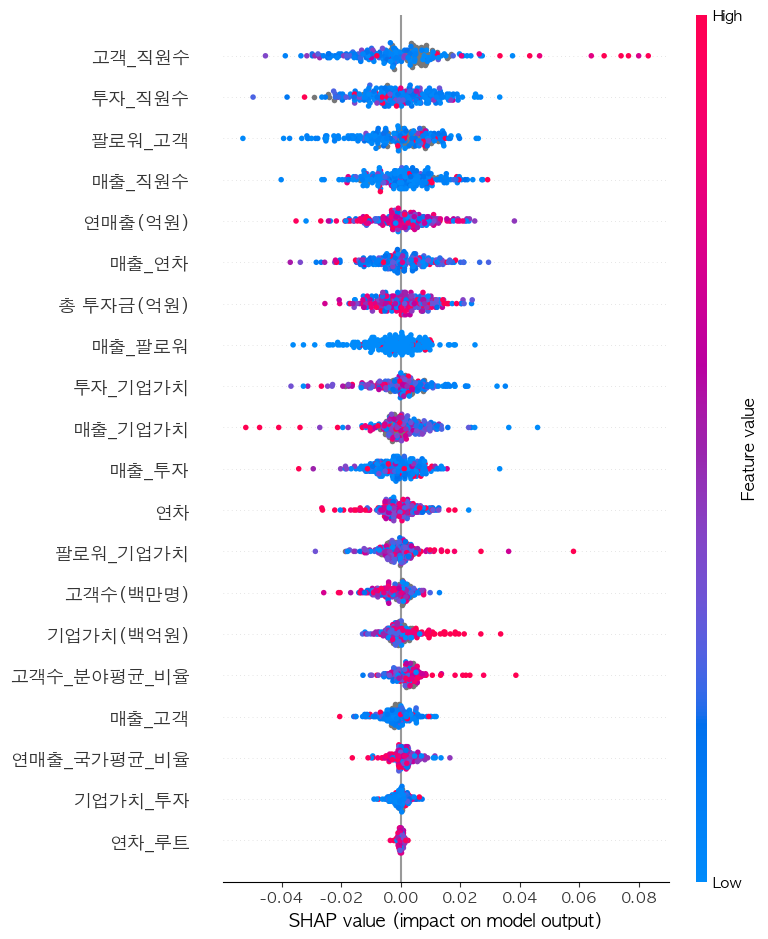

In [27]:
import shap
import matplotlib.pyplot as plt

# macOS: AppleGothic 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid)


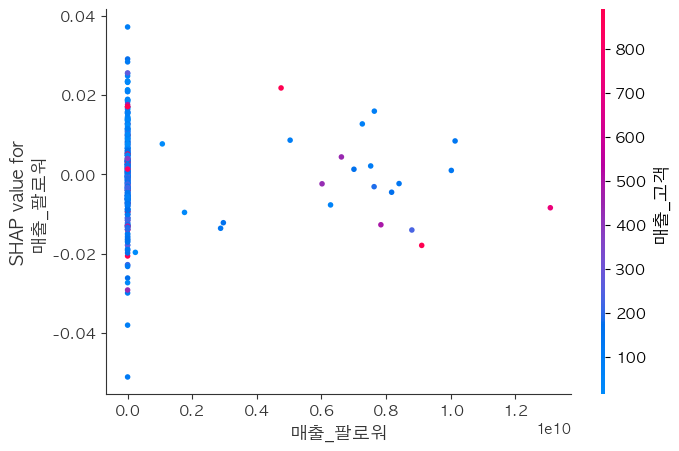

In [54]:
shap.dependence_plot("매출_팔로워", shap_values, X_valid)


In [35]:
import pandas as pd

# 두 파일 불러오기
file1 = '0414_09_submission.csv'
file2 = '0414_13_submission.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# '성공확률' 컬럼 기준으로 평균 계산
df_ensemble = df1.copy()
df_ensemble['성공확률'] = (df1['성공확률'] + df2['성공확률']) / 2

# 새로운 제출 파일로 저장
df_ensemble.to_csv('0414_ensemble_submission.csv', index=False, encoding='utf-8-sig')
